In [42]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import copy
import scipy
from errorResult import MSE
from errorResult import RMSE
from errorResult import jdwucha
from errorResult import xdwucha
from errorResult import fanguiy
from errorResult import result
from errorResult import drawAll

def f(lmd,c):
    # return scipy.special.expit(-lmd*c)
    y = 1 / (1 + np.exp(-0.5*c))
    return y

def h(err):
    y = 1 / (2 * err + 1)
    return y

def errorLp(p,data_pre,data_real):
    dist = np.linalg.norm(data_pre-data_real,ord=p)/(data_pre.shape[0]*data_pre.shape[1])
    return dist
  
#%%
#返回初始化权重参数   NxN 
def initialize_parameters_he(npop,N):
    parameters = np.zeros((npop,N*N))
    for i in range(npop):
        parameter = np.random.uniform(-1,1,N*(N-1))
        #np.random.randn(N*(N-1)) * np.sqrt(2.0 / (N*(N-1)))
        lmd = np.random.uniform(0,1,N)
        #lmd = np.array([1]*N)
        parameters[i] = parameter.tolist()+lmd.tolist()
    return parameters
    
def rshape(X,N):
    temp = copy.copy(X)
    e = np.zeros((N,N))
    param = temp[:-N]   
    lmd = temp[-N:]
    num = 0
    for i in range(N):
        for j in range(N):
            if i is not j:
                e[i,j] = param[num]
                num = num + 1
    return e,lmd
    
#jaya学习算法训练FCM参数
def jayaTrain(c_data,c_real,time,N,npop=4):
    X = initialize_parameters_he(npop,N)
    print(rshape(X[1,:],N))
#    for n in range(npop):
#        for i in range(N*N):
#            X[n,i] = min(X[:,i]) + np.random.random()*(max(X[:,i])-min(X[:,i]))
    fitness = np.zeros(npop)
    error = np.zeros(npop)
    worst= 0
    best = 0
    error_time = []
    c_pre = np.zeros((c_real.shape[0],c_real.shape[1]))
    for num in range(1500):
        for n in range(npop):
            e,lmd = rshape(X[n,:],N)
            #print("c_data.shape: %s" % c_data.shape)
            c_pre = fcm(e,lmd,c_data,c_real,time)
            #print("c_pre, c_real: %s ,%s" % c_pre.shape, c_real.shape)
            fitness[n] = h(errorLp(2,c_pre,c_real)) 
            error[n] = errorLp(2,c_pre,c_real)
        worst = fitness.tolist().index(min(fitness))
        best = fitness.tolist().index(max(fitness))
        print(worst,best,fitness)
    
        Xx = np.zeros((npop,N*N))
        for n in range(npop):
            Xx[n,:] = X[n,:] + (X[best,:]-np.abs(X[n,:]))*np.random.random()-(X[worst,:]-np.abs(X[n,:]))*np.random.random()
            for i in range(N*N):
                if Xx[n,i] < min(Xx[:,i]):
                    Xx[n,i] = min(Xx[:,i])
                if Xx[n,i] > max(Xx[:,i]):
                    Xx[n,i] = max(Xx[:,i])
            e,lmd = rshape(Xx[n,:],N)
            c_pre = fcm(e,lmd,c_data,c_real,time)
            error2 = errorLp(2,c_pre,c_real)
            if error2 <= error[n]:
                X[n,:] = Xx[n,:]              
        error_time.append(error[best])
    e,lmd = rshape(X[best,:],N)
    return e,lmd,error_time

#模糊认知图递推过程      
def fcm(e,lmd,data_front,data,time):
    '''
    c_len = len(data)
    data_pre = np.zeros((time+1,c_len))
    data_pre[0] = data_front
    
    for t in range(0,time):
        for i in range(c_len):
            for j in range(c_len):
                if i is not j :
                    data_pre[t+1,i] += e[j,i]*data[t,j]
            data_pre[t+1,i] += data[t,i]
            data_pre[t+1,i] = f(lmd[i],data[t+1,i])
    
    '''
    c_len = len(data_front)
    data_pre = np.zeros((time,c_len))
    data_pre[0] = np.dot(data_front,e)
    for i in range(c_len):
        data_pre[0,i] = f(lmd[i],data_pre[0,i])
    for t in range(0,time-1):
        data_pre[t+1] = np.dot(data[t],e)
        for i in range(c_len):
            data_pre[t+1,i] = f(lmd[i],data_pre[t+1,i])
    return data_pre

#模糊认知图递推过程训练用   
def fcmm(e,lmd,data_front):
    c_len = len(data_front)
    data_pre = np.dot(data_front,e)
    for i in range(c_len):
        data_pre[i] = f(lmd[i],data_pre[i])
    
    return data_pre

In [43]:
#%% 
if __name__ == "__main__":
    data = pd.read_csv('dataProcess.csv',index_col = 0)
    data = np.array(data)
    train_time = 504               #设置滑动窗口
    start = 1
    hour = 100   
    concept = data.shape[1]
    
    #data_train = data[240:600,:]   #20天做训练
    data_test = data[start+train_time:start+train_time+hour,:]     #3天做测试
    data_pre = np.zeros((data_test.shape[0],data_test.shape[1]))
    data_train = data[start:train_time+start,:]
    
    e,lmd,error_time = jayaTrain(data[start-1,:],data_train,train_time,concept,npop = 8)
    
    for i in range(0,hour):
        #data_train = data[i+start:i+train_time+start,:]
        data_real = data[i+start+train_time-1,:]
        #e,lmd,error_time = jayaTrain(data[i+start-1,:],data_train,train_time,concept,npop = 8)
        data_pre[i] = fcmm(e,lmd,data_real)   

(array([[ 0.        , -0.85196802, -0.00953427,  0.28356863,  0.42521654,
         0.88206234],
       [ 0.14430804,  0.        ,  0.2011827 ,  0.9923594 ,  0.25671187,
        -0.81809775],
       [-0.42818929,  0.48940734,  0.        , -0.70709877,  0.161506  ,
        -0.5719563 ],
       [ 0.10823727,  0.99279906, -0.88092166,  0.        ,  0.85044887,
         0.27776407],
       [ 0.33517885,  0.25507722,  0.19655385,  0.47137181,  0.        ,
         0.92843177],
       [-0.0114491 ,  0.2909636 , -0.89730055, -0.19331629,  0.79597618,
         0.        ]]), array([0.67921786, 0.21372327, 0.63867684, 0.61587298, 0.68506122,
       0.78270236]))
0 3 [0.98613031 0.98654309 0.98642965 0.98697923 0.98675836 0.98669943
 0.98667108 0.98696954]
6 1 [0.98748688 0.98785176 0.98691846 0.98697923 0.98675836 0.98669943
 0.98667108 0.98773934]
5 6 [0.98832356 0.98884261 0.98848191 0.98838656 0.98794177 0.98681168
 0.98903091 0.98773934]
4 6 [0.98876603 0.98884261 0.98997382 0.99050109 0.987

6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0.99543488 0.99545958
 0.99533958 0.99543075]
6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0.99543488 0.99545958
 0.99533958 0.99543075]
6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0.99543488 0.99545958
 0.99533958 0.99543075]
6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0.99543488 0.99545958
 0.99533958 0.99543075]
6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0.99543488 0.99545958
 0.99533958 0.99543075]
6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0.99543488 0.99545958
 0.99533958 0.99543075]
6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0.99543488 0.99545958
 0.99533958 0.99543075]
6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0.99543488 0.99545958
 0.99533958 0.99543075]
6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0.99543488 0.99545958
 0.99533958 0.99543075]
6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0.99543488 0.99545958
 0.99533958 0.99543075]
6 1 [0.99544697 0.99546056 0.99537224 0.99542376 0

2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0.99543488 0.99545958
 0.99545142 0.99543075]
2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0.99543488 0.99545958
 0.99545142 0.99543075]
2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0.99543488 0.99545958
 0.99545142 0.99543075]
2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0.99543488 0.99545958
 0.99545142 0.99543075]
2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0.99543488 0.99545958
 0.99545142 0.99543075]
2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0.99543488 0.99545958
 0.99545142 0.99543075]
2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0.99543488 0.99545958
 0.99545142 0.99543075]
2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0.99543488 0.99545958
 0.99545142 0.99543075]
2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0.99543488 0.99545958
 0.99545142 0.99543075]
2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0.99543488 0.99545958
 0.99545142 0.99543075]
2 3 [0.99545379 0.99546065 0.99537224 0.99550575 0

7 3 [0.99545379 0.99546065 0.99549769 0.99550575 0.99546161 0.9954922
 0.99545142 0.99544606]
7 3 [0.99545379 0.99546065 0.99549769 0.99550575 0.99546161 0.9954922
 0.99545142 0.99544606]
7 3 [0.99545379 0.99546065 0.99549769 0.99550575 0.99546161 0.9954922
 0.99545142 0.99544606]
7 3 [0.99545379 0.99546065 0.99549769 0.99550575 0.99546161 0.9954922
 0.99545142 0.99544606]
7 3 [0.99545379 0.99546065 0.99549769 0.99550575 0.99546161 0.9954922
 0.99545142 0.99544606]
7 3 [0.99545605 0.99546065 0.99549769 0.99550575 0.99546161 0.9954922
 0.99545142 0.99544606]
7 3 [0.99545605 0.99546065 0.99549769 0.99550575 0.99546161 0.9954922
 0.99545142 0.99544606]
7 3 [0.99545605 0.99546065 0.99549769 0.99550575 0.99546161 0.9954922
 0.99545142 0.99544606]
7 3 [0.99545605 0.99546065 0.99549769 0.99550575 0.99546161 0.9954922
 0.99545142 0.99544606]
7 3 [0.99545605 0.99546065 0.99549769 0.99550575 0.99546161 0.9954922
 0.99545142 0.99544606]
7 3 [0.99545605 0.99546065 0.99549769 0.99550575 0.99546161 

0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0.99548388 0.99552751
 0.99549962 0.99548265]
0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0.99548388 0.99552751
 0.99549962 0.99548265]
0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0.99548388 0.99552751
 0.99549962 0.99548265]
0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0.99548388 0.99552751
 0.99549962 0.99548265]
0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0.99548388 0.99552751
 0.99549962 0.99548265]
0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0.99548388 0.99552751
 0.99549962 0.99548265]
0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0.99548388 0.99552751
 0.99549962 0.99548265]
0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0.99548388 0.99552751
 0.99549962 0.99548265]
0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0.99548388 0.99552751
 0.99549962 0.99548265]
0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0.99548388 0.99552751
 0.99549962 0.99548265]
0 5 [0.99545925 0.99546849 0.99550124 0.99550575 0

0 5 [0.99546255 0.99546849 0.99550719 0.99550664 0.99549966 0.99552751
 0.99550216 0.99550766]
0 5 [0.99546255 0.99546849 0.99550719 0.99550664 0.99549966 0.99552751
 0.99550216 0.99550766]
0 5 [0.99546255 0.99546849 0.99550719 0.99550664 0.99549966 0.99552751
 0.99550216 0.99550766]
0 5 [0.99546255 0.99546849 0.99550719 0.99550664 0.99549966 0.99552751
 0.99550216 0.99550766]
0 5 [0.99546255 0.99546849 0.99550719 0.99550664 0.99549966 0.99552751
 0.99550216 0.99550766]
0 5 [0.99546255 0.99546849 0.99550719 0.99550664 0.99549966 0.99552751
 0.99550216 0.99550766]
0 5 [0.99546255 0.99546849 0.99550719 0.99550664 0.99549966 0.99552751
 0.99550216 0.99550766]
0 5 [0.99546255 0.99546849 0.99550719 0.99550664 0.99549966 0.99552751
 0.99550216 0.99550766]
0 5 [0.99546255 0.99546849 0.99550719 0.99550664 0.99549966 0.99552751
 0.99550216 0.99550766]
0 5 [0.99546255 0.99546955 0.99550719 0.99550664 0.99549966 0.99552751
 0.99550216 0.99550766]
0 5 [0.99546255 0.99546955 0.99550719 0.99550664 0

1 6 [0.995499   0.99548589 0.99550782 0.99551322 0.99549966 0.99552751
 0.99553828 0.99552216]
1 6 [0.995499   0.99548589 0.99550782 0.99551322 0.99549966 0.99552751
 0.99553828 0.99552216]
1 6 [0.995499   0.99548589 0.99550782 0.99551322 0.99549966 0.99552751
 0.99553828 0.99552216]
1 6 [0.995499   0.99548589 0.99550782 0.99551322 0.99549966 0.99552751
 0.99553828 0.99552216]
1 6 [0.995499   0.99548589 0.99550782 0.99551322 0.99549966 0.99552751
 0.99553828 0.99552216]
1 6 [0.995499   0.99548589 0.99550782 0.99551322 0.99549966 0.99552751
 0.99553828 0.99552216]
1 6 [0.995499   0.99548589 0.99550782 0.99551322 0.99549966 0.99552751
 0.99553828 0.99552216]
1 6 [0.995499   0.99548589 0.99550782 0.99551322 0.99549966 0.99552751
 0.99553828 0.99552216]
1 6 [0.995499   0.99548589 0.99550782 0.99551322 0.99549966 0.99552751
 0.99553828 0.99552216]
1 6 [0.995499   0.99548589 0.99550782 0.99551322 0.99549966 0.99552751
 0.99553828 0.99552216]
1 6 [0.995499   0.99548589 0.99550782 0.99551322 0

2 4 [0.99552259 0.99553682 0.99550782 0.99551322 0.99554153 0.99553004
 0.99553828 0.99552216]
2 4 [0.99552259 0.99553682 0.99550782 0.99551322 0.99554153 0.99553004
 0.99553828 0.99552216]
2 4 [0.99552259 0.99553682 0.99550782 0.99551322 0.99554153 0.99553004
 0.99553828 0.99552216]
2 4 [0.99552259 0.99553682 0.99550782 0.99551322 0.99554153 0.99553004
 0.99553828 0.99552216]
2 4 [0.99552259 0.99553682 0.99550782 0.99551322 0.99554153 0.99553004
 0.99553828 0.99552216]
2 4 [0.99552259 0.99553682 0.99550782 0.99551322 0.99554153 0.99553004
 0.99553828 0.99552216]
2 4 [0.99552259 0.99553682 0.99550782 0.99551322 0.99554153 0.99553004
 0.99553828 0.99552216]
2 4 [0.99552259 0.99553682 0.99550782 0.99551322 0.99554153 0.99553004
 0.99553828 0.99552216]
2 5 [0.99552259 0.99553682 0.99550782 0.99551322 0.99554153 0.995559
 0.99553828 0.99552216]
2 5 [0.99552259 0.99553682 0.99550782 0.99551322 0.99554153 0.995559
 0.99553828 0.99552216]
2 5 [0.99552259 0.99553682 0.99550782 0.99551322 0.995

2 4 [0.99560806 0.99565823 0.99554821 0.99565478 0.99566516 0.99562971
 0.99560708 0.99563131]
2 4 [0.99560806 0.99565823 0.99554821 0.99565478 0.99566516 0.99562971
 0.99560708 0.99563131]
2 4 [0.99560806 0.99565823 0.99554821 0.99565478 0.99566516 0.99562971
 0.99560708 0.99563131]
2 3 [0.99560806 0.99565823 0.99554821 0.99571055 0.99566516 0.99562971
 0.99560708 0.99563131]
2 3 [0.99560806 0.99565823 0.99554821 0.99571055 0.99566516 0.99562971
 0.99560708 0.99563131]
2 3 [0.99560806 0.99565823 0.99554821 0.99571055 0.99566516 0.99562971
 0.99560708 0.99563131]
6 3 [0.99560806 0.99567833 0.99569432 0.99571055 0.99566516 0.995672
 0.99560708 0.99563131]
0 3 [0.99560806 0.99567833 0.99569432 0.99571055 0.99566516 0.995672
 0.99569257 0.99563131]
0 3 [0.99560806 0.99567833 0.99569432 0.99571055 0.99566516 0.995672
 0.99569257 0.99563131]
0 3 [0.99560806 0.99567833 0.99569432 0.99571055 0.99566516 0.995672
 0.99569257 0.99563131]
0 3 [0.99560806 0.99567833 0.99569432 0.99571055 0.9956651

3 2 [0.9957384  0.99575014 0.99580904 0.99571055 0.99574944 0.99574429
 0.99575427 0.99578397]
3 2 [0.9957384  0.99575014 0.99580904 0.99571055 0.99574944 0.99574429
 0.99575427 0.99578397]
3 2 [0.9957384  0.99575014 0.99580904 0.99571055 0.99574944 0.99574429
 0.99575427 0.99578397]
3 2 [0.9957384  0.99575014 0.99580904 0.99571055 0.99574944 0.99574429
 0.99575427 0.99578397]
3 2 [0.9957384  0.99580868 0.99580904 0.99571055 0.99574944 0.99574429
 0.99575427 0.99578857]
3 2 [0.99574015 0.99580868 0.99580904 0.99571055 0.99574944 0.99574429
 0.99575427 0.99578857]
3 2 [0.99574015 0.99580868 0.99580904 0.99571055 0.99574944 0.99574429
 0.99575427 0.99578857]
3 2 [0.99574015 0.99580868 0.99580904 0.99571055 0.99574944 0.99574429
 0.99575427 0.99578857]
3 1 [0.99574015 0.99583379 0.99580904 0.99571055 0.99574944 0.99574429
 0.99575427 0.99578857]
3 1 [0.99574015 0.99583379 0.99580904 0.99571055 0.99574944 0.99574429
 0.99575427 0.99578857]
3 1 [0.99574015 0.99583379 0.99580904 0.99571055 0

6 7 [0.99584508 0.99583379 0.99584119 0.99581309 0.99585365 0.99586406
 0.9957995  0.9958762 ]
6 7 [0.99584508 0.99583379 0.99584119 0.99581309 0.99585365 0.99586406
 0.9957995  0.9958762 ]
6 7 [0.99584508 0.99583379 0.99584119 0.99581309 0.99585365 0.99586406
 0.9957995  0.9958762 ]
6 7 [0.99584508 0.99583379 0.99584119 0.99581309 0.99585365 0.99586406
 0.9957995  0.9958762 ]
6 7 [0.99584508 0.99583379 0.99584119 0.99581309 0.99585365 0.99586406
 0.9957995  0.9958762 ]
6 7 [0.99584508 0.99583379 0.99584119 0.99581309 0.99585365 0.99586406
 0.9957995  0.9958762 ]
6 7 [0.99584508 0.99583379 0.99584119 0.99581309 0.99585365 0.99586406
 0.9957995  0.9958762 ]
6 7 [0.99584508 0.99586397 0.99584119 0.99581309 0.99585365 0.99586406
 0.9957995  0.9958762 ]
6 7 [0.99584508 0.99586397 0.99584119 0.99581309 0.99585365 0.99586406
 0.9957995  0.9958762 ]
6 7 [0.99584508 0.99586397 0.99584119 0.99581309 0.99585365 0.99586406
 0.9957995  0.9958762 ]
6 7 [0.99584508 0.99586397 0.99584119 0.99581309 0

3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0.99587759 0.99589669
 0.99590622 0.99588962]
3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0.99587759 0.99589669
 0.99590622 0.99588962]
3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0.99587759 0.99589669
 0.99590622 0.99588962]
3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0.99587759 0.99589669
 0.99590622 0.99588962]
3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0.99587759 0.99589669
 0.99590622 0.99588962]
3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0.99587759 0.99589669
 0.99590622 0.99588962]
3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0.99587759 0.99589669
 0.99590622 0.99588962]
3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0.99587759 0.99589669
 0.99590622 0.99588962]
3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0.99587759 0.99589669
 0.99590622 0.99588962]
3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0.99587759 0.99589669
 0.99590622 0.99588962]
3 1 [0.99584856 0.99590761 0.99584119 0.99581309 0

3 7 [0.9959023  0.9959112  0.99589099 0.9958875  0.99589706 0.99589669
 0.99590622 0.99591399]
3 7 [0.9959023  0.9959112  0.99589099 0.9958875  0.99589706 0.99589669
 0.99590622 0.99591399]
3 7 [0.9959023  0.9959112  0.99589099 0.9958875  0.99589706 0.99589669
 0.99590622 0.99591399]
3 7 [0.9959023  0.9959112  0.99589099 0.9958875  0.99589706 0.99589669
 0.99590622 0.99591399]
3 7 [0.9959023  0.9959112  0.99589099 0.9958875  0.99589706 0.99589669
 0.99590622 0.99591399]
3 7 [0.9959023  0.9959112  0.99589099 0.9958875  0.99589706 0.99590864
 0.99590622 0.99591399]
3 7 [0.9959023  0.9959112  0.99589099 0.9958875  0.99589706 0.99590864
 0.99590622 0.99591399]
3 7 [0.9959023  0.9959112  0.99589099 0.9958875  0.99589706 0.99590864
 0.99590622 0.99591399]
3 7 [0.9959023  0.9959112  0.99589099 0.9958875  0.99589706 0.99590864
 0.99590622 0.99591399]
3 7 [0.9959023  0.9959112  0.99589099 0.9958875  0.99589706 0.99590864
 0.99590622 0.99591399]
3 7 [0.9959023  0.9959112  0.99590945 0.9958875  0

3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.9958875  0

3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0.99591399 0.99590864
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 0 [0.99591865 0.99591377 0.99590945 0.99590102 0

3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0.99591399 0.99591057
 0.99591046 0.99591399]
3 1 [0.99591865 0.99592002 0.99590945 0.99590102 0

3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0.99591399 0.99591057
 0.99591046 0.99592436]
3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0.99591399 0.99591057
 0.99591046 0.99592436]
3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0.99591399 0.99591057
 0.99591046 0.99592436]
3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0.99591399 0.99591057
 0.99591046 0.99592436]
3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0.99591399 0.99591057
 0.99591046 0.99592436]
3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0.99591399 0.99591057
 0.99591046 0.99592436]
3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0.99591399 0.99591057
 0.99591046 0.99592436]
3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0.99591399 0.99591057
 0.99591046 0.99592436]
3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0.99591399 0.99591057
 0.99591046 0.99592436]
3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0.99591399 0.99591057
 0.99591046 0.99592436]
3 7 [0.99591865 0.99592002 0.99590945 0.99590536 0

3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0.99591399 0.99591057
 0.99591046 0.9959251 ]
3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0.99591399 0.99591057
 0.99591046 0.9959251 ]
3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0.99591399 0.99591057
 0.99591046 0.9959251 ]
3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0.99591399 0.99591057
 0.99591046 0.9959251 ]
3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0.99591399 0.99591057
 0.99591046 0.9959251 ]
3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0.99591399 0.99591057
 0.99591046 0.9959251 ]
3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0.99591399 0.99591057
 0.99591046 0.9959251 ]
3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0.99591399 0.99591057
 0.99591046 0.9959251 ]
3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0.99591399 0.99591057
 0.99591046 0.9959251 ]
3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0.99591399 0.99591057
 0.99591046 0.9959251 ]
3 7 [0.99591865 0.99592002 0.99590945 0.99590931 0

0.006829846530009501


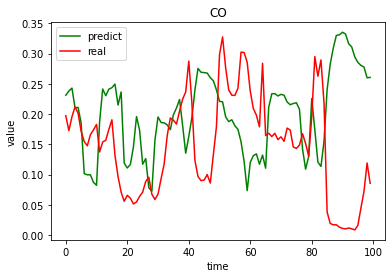

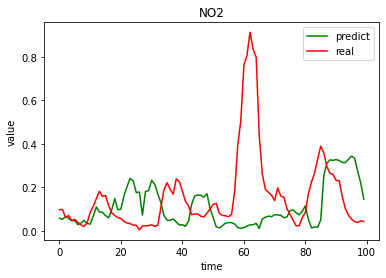

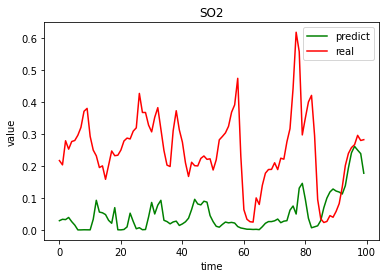

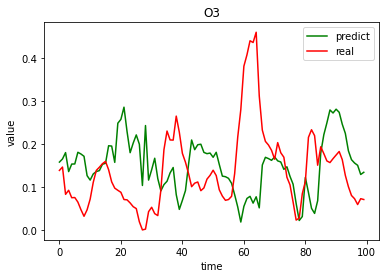

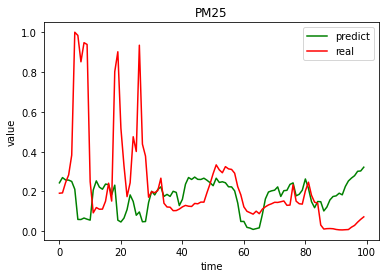

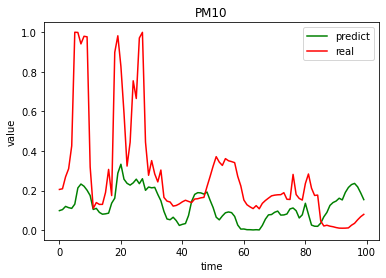

In [44]:
drawAll(data_pre,data_test)
result(data_pre,data_test,'jaya')

In [49]:
print(e)

[[  0.         -20.24140198  -5.5450729   -1.68123065   5.9996279
  -10.44937225]
 [ -3.08108315   0.          -1.44892959  -5.42121047  -9.81789354
  -11.59302923]
 [ -5.88271548  -1.90760204   0.         -12.02906062  -4.63417205
   -5.88126201]
 [ -1.74613968  -6.47239682 -19.74922507   0.          -1.97063581
   -0.95273206]
 [  0.80013871  -3.94125714  -2.08776169  -2.69231926   0.
    1.50389173]
 [ -3.22095877   1.33688314 -11.41438914   3.60557332  -4.58659406
    0.        ]]


In [50]:
print(lmd)

[-1.08285576  1.58684925  2.21805865 -0.17937711 -4.10759609  0.59884057]


In [1]:
a = 0.006829846530009501*6